## Import Libraries

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import VGG16
import pandas as pd
import zipfile
import re
import os
import pathlib
print(tf.__version__)

1.14.0


##Mount the Drive to access the image data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##Import Dataset

#### Extract the training and testing zip files

In [0]:
# Extracting train.zip into the drive
train_zf = zipfile.ZipFile("/content/drive/My Drive/aptos2019-blindness-detection/train_images.zip")
train_zf.extractall(path='/content/drive/My Drive/aptos2019-blindness-detection/train')

# Extracting test.zip into the drive
test_zf = zipfile.ZipFile("/content/drive/My Drive/aptos2019-blindness-detection/test_images.zip")
test_zf.extractall(path='/content/drive/My Drive/aptos2019-blindness-detection/test')

#### Check if the created folders-train and test contain correct number of images or not

In [0]:
import os, os.path

DIR_test = '/content/drive/My Drive/aptos2019-blindness-detection/test'
DIR_train = '/content/drive/My Drive/aptos2019-blindness-detection/train'

print(len([name for name in os.listdir(DIR_test) if os.path.isfile(os.path.join(DIR_test, name))]))
print(len([name for name in os.listdir(DIR_train) if os.path.isfile(os.path.join(DIR_train, name))]))

1928
3662


####Create Dataframes from the csv files. Convert the id_code in the files to match the image names by apending .png

In [0]:
def append_ext(fn):
    return fn+".png"
  
traindf=pd.read_csv('/content/drive/My Drive/aptos2019-blindness-detection/train.csv',dtype=str)
testdf=pd.read_csv("/content/drive/My Drive/aptos2019-blindness-detection/test.csv",dtype=str)

traindf["id_code"]=traindf["id_code"].apply(append_ext)
testdf["id_code"]=testdf["id_code"].apply(append_ext)

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

#### Create training and validation data generators by splitting the training data.(75% training +25% validation)

In [0]:
# Data Augmentation with roration, shifting, flipping images  

train_generator=datagen.flow_from_dataframe(dataframe=traindf,
directory="/content/drive/My Drive/aptos2019-blindness-detection/train/",
x_col="id_code",
y_col="diagnosis",
subset="training",
color_mode="rgb",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32),
rotation_range=20,
width_shift_range=0.2,  #
height_shift_range=0.2,
horizontal_flip=True, # randomly flips inputs horizontally
vertical_flip=True) # randomly flips inputs vertically

valid_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="/content/drive/My Drive/aptos2019-blindness-detection/train/",
x_col="id_code",
y_col="diagnosis",
subset="validation",
color_mode="rgb",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32),
rotation_range=20,
width_shift_range=0.2,  
height_shift_range=0.2,
horizontal_flip=True,
vertical_flip=True)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 14 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2736 validated image filenames belonging to 5 classes.
Found 912 validated image filenames belonging to 5 classes.


#### Create the test datagenerator from the test data. Further which can be used for predictions

In [0]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory="/content/drive/My Drive/aptos2019-blindness-detection/test/",
x_col="id_code",
y_col=None,
batch_size=32,
color_mode="rgb",
seed=42,
shuffle=False,
class_mode=None,
target_size=(32,32))

Found 1928 validated image filenames.


In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

##Model - Dense121

In [0]:
from keras.applications.densenet import DenseNet121
from keras.activations import softmax, relu
from keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, BatchNormalization
from keras.models import Sequential, Model

input_tensor=Input(shape=(32, 32,3))  
dense121_model5 =DenseNet121(weights='imagenet', include_top=False, 
                             input_tensor= input_tensor)    
x=GlobalAveragePooling2D()(dense121_model5.output)
x=Dropout(0.3)(x)
x=Dense(32, activation=relu)(x)
x=Dropout(0.2)(x)
x=BatchNormalization()(x)
output_layer=Dense(5,activation='softmax', name="Output_Layer")(x)
fine_tuning_dense121_model5 =Model(input_tensor, output_layer)

W0724 23:04:20.440896 139913733465984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



29089792/29084464 [==============================] - 1s 0us/step


### Model Compile

In [0]:

from keras.optimizers import Adam, rmsprop, RMSprop
import gc

lr = 0.2
optimizer=rmsprop(lr=lr,decay=0.2)
fine_tuning_dense121_model5.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,  metrics=['accuracy'])

###Early Processing

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

rLRp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='auto', epsilon=0.0001)
es = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=12)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


### Model Fit

In [0]:
fine_tuning_dense121_model5_history=fine_tuning_dense121_model5.fit_generator(generator=train_generator,
                           steps_per_epoch=len(train_generator),
                           validation_data=valid_generator,
                           validation_steps=len(valid_generator),
                           epochs=5,
                           callbacks = [es, rLRp], 
                           use_multiprocessing = True,                    
                           verbose=2)

Epoch 1/5
 - 380s - loss: 0.6893 - acc: 0.7525 - val_loss: 0.8037 - val_acc: 0.7127
Epoch 2/5
 - 347s - loss: 0.7039 - acc: 0.7500 - val_loss: 0.7556 - val_acc: 0.7292
Epoch 3/5
 - 356s - loss: 0.6818 - acc: 0.7529 - val_loss: 0.8174 - val_acc: 0.6853
Epoch 4/5
 - 374s - loss: 0.6873 - acc: 0.7543 - val_loss: 0.8147 - val_acc: 0.7029
Epoch 5/5
 - 370s - loss: 0.6741 - acc: 0.7565 - val_loss: 0.7283 - val_acc: 0.7489


In [0]:
print("Model maximum accuracy:",max(fine_tuning_dense121_model5_history.history['val_acc']))

Model maximum accuracy: 0.7489035087719298


### Accuracy Plot

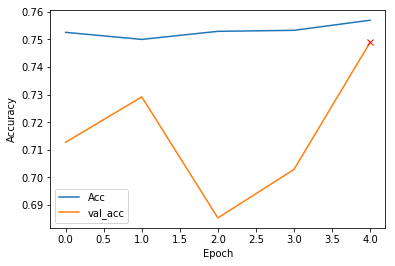

In [0]:
accu=fine_tuning_dense121_model5_history.history['acc']
val_acc=fine_tuning_dense121_model5_history.history['val_acc']

plt.plot(accu,label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc','val_acc'])
plt.plot( np.argmax(fine_tuning_dense121_model5_history.history["val_acc"]), np.max(fine_tuning_dense121_model5_history.history["val_acc"]), marker="x", color="r", label="best model")
plt.show()

### Loss Plot

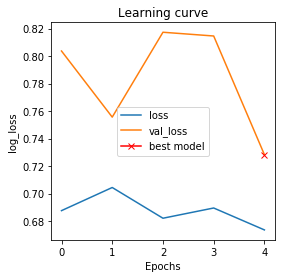

In [0]:
plt.figure(figsize=(4,4))
plt.title("Learning curve")
plt.plot(fine_tuning_dense121_model5_history.history["loss"], label="loss")
plt.plot(fine_tuning_dense121_model5_history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(fine_tuning_dense121_model5_history.history["val_loss"]), np.min(fine_tuning_dense121_model5_history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

## Confusion Matrix for validation data

In [0]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = fine_tuning_dense121_model5.predict_generator(valid_generator, len(valid_generator)) #test_generator.n//test_generator.batch_size+1) # num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cnf_matrix= confusion_matrix(valid_generator.classes, y_pred)
print(cnf_matrix)
print('Classification Report')
target_names = ['0 - No DR','1 - Mild','2 - Moderate','3 - Severe','4 - Proliferative DR']
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[212  25 185   0   0]
 [ 45  10  41   0   0]
 [129  13 127   0   0]
 [ 22   1  26   0   0]
 [ 30   4  42   0   0]]
Classification Report
                      precision    recall  f1-score   support

           0 - No DR       0.48      0.50      0.49       422
            1 - Mild       0.19      0.10      0.13        96
        2 - Moderate       0.30      0.47      0.37       269
          3 - Severe       0.00      0.00      0.00        49
4 - Proliferative DR       0.00      0.00      0.00        76

            accuracy                           0.38       912
           macro avg       0.19      0.22      0.20       912
        weighted avg       0.33      0.38      0.35       912



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Confusion matrix Heat Map

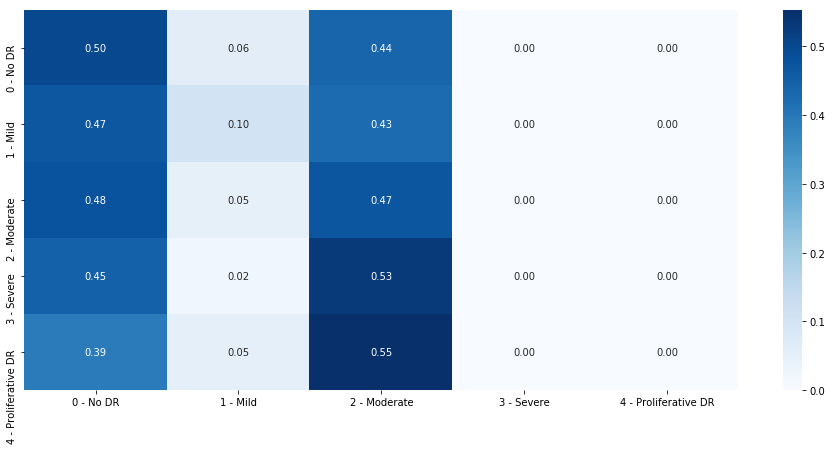

In [0]:
#Heat Map

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

labels=['0 - No DR','1 - Mild','2 - Moderate','3 - Severe','4 - Proliferative DR']

cnf_matrix_norm=cnf_matrix.astype('float')/cnf_matrix.sum(axis=1)[:,np.newaxis]
df_cm=pd.DataFrame(cnf_matrix_norm,index=labels,columns=labels)

plt.figure(figsize=(16,7))
sns.heatmap(df_cm,annot=True,fmt='.2f',cmap='Blues')
plt.show()

### Model Prediction

In [0]:
from tqdm import tqdm


tta_steps = 10
preds_tta=[]

for i in tqdm(range(tta_steps)):
    test_generator.reset()
    preds = fine_tuning_resnet_model.predict_generator(generator=test_generator,steps =len(test_generator))
#     print('Before ', preds.shape)
    preds_tta.append(preds)
#     print(i,  len(preds_tta))

100%|██████████| 10/10 [11:38<00:00, 69.81s/it]


In [0]:
final_pred = np.mean(preds_tta, axis=0)
predicted_class_indices = np.argmax(final_pred, axis=1)
len(predicted_class_indices)

1928

In [0]:
#test_generator.filenames.apply(lambda x: x[-4])
results=pd.DataFrame({"id_code":test_generator.filenames, "diagnosis":predicted_class_indices})  
results.id_code=results.id_code.apply(lambda x: x[:-4])
results.to_csv("submission.csv", index=False)
results.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
